# Women's NCAA Tournament Prediction: Model Comparison and Brier Score Optimization

This notebook explores various machine learning models to predict outcomes in the Women's NCAA Basketball Tournament. Our primary goal is to optimize the Brier score, a metric that evaluates the accuracy of probabilistic predictions.

We experiment with the following models:

* **XGB Survival Model:** A survival analysis approach to predict the time-to-event (tournament progression).
* **XGB Classifier:** A gradient boosting classifier for direct game outcome prediction.
* **Extra Trees Classifier:** An ensemble method utilizing multiple randomized decision trees.
* **Support Vector Machine (SVM) Models:** Utilizing different kernels and feature sets.
    * **Including GNN Embeddings:** We train a Graph Neural Network (GNN) and utilize its generated embeddings as additional features in the SVM classifier.
    * **Including KMeans Clustering:** We incorporate KMeans clustering to create a continuous feature representing cluster assignments, which is then used in the SVM classifier.

To ensure robust evaluation and minimize overfitting, we employ cross-validation. Specifically, each model is trained and evaluated using 5 distinct test sets, where each test set encompasses three consecutive tournament seasons. This cross-validation strategy provides a comprehensive assessment of model performance across diverse time periods.

The notebook focuses on fine-tuning model parameters and feature sets, including GNN embeddings and KMeans clustering, to minimize the Brier score, ultimately aiming to achieve the most accurate probabilistic predictions for Women's NCAA Tournament outcomes.

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, brier_score_loss
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import torch
import torch_geometric.data
import torch_geometric.nn
import torch.nn.functional as F
import torch.optim as optim
import warnings
import itertools
import csv
import os
warnings.filterwarnings('ignore')
from sklearn.neighbors import NearestNeighbors
from scripts import modeling_functions as mf


# Set a seed value 
seed_value = 42

#  Set seed for NumPy
np.random.seed(seed_value)

#  Set seed for PyTorch
torch.manual_seed(seed_value)

# Set seed for os environment variables.
os.environ['PYTHONHASHSEED'] = str(seed_value)

# Rest of your PyTorch and NumPy code...

training_data=pd.read_csv('data/processed/womens_processed_data.csv')
training_data=pd.get_dummies(training_data,columns=['Reg_ConfAbbrev','Opponent_reg_ConfAbbrev'])
training_data.head()

,Game_ID,Season,DayNum,Game_Score,Game_Loc,Game_FGM,Game_FGA,Game_FGM3,Game_FGA3,Game_FTM,...,Opponent_reg_ConfAbbrev_pac_twelve,Opponent_reg_ConfAbbrev_patriot,Opponent_reg_ConfAbbrev_sec,Opponent_reg_ConfAbbrev_southern,Opponent_reg_ConfAbbrev_southland,Opponent_reg_ConfAbbrev_summit,Opponent_reg_ConfAbbrev_sun_belt,Opponent_reg_ConfAbbrev_swac,Opponent_reg_ConfAbbrev_wac,Opponent_reg_ConfAbbrev_wcc
0,0,2010,138,69,N,28,57,1,5,12,...,False,False,False,False,False,False,False,False,True,False
1,1,2010,138,67,N,23,59,9,26,12,...,False,False,False,False,False,False,False,False,False,False
2,2,2010,138,72,H,26,57,4,13,16,...,False,False,False,False,False,False,False,False,False,False
3,3,2010,138,75,H,25,63,3,15,22,...,False,False,False,False,False,False,False,False,True,False
4,4,2010,138,62,N,24,68,8,25,6,...,False,False,False,False,False,False,False,False,False,False


# XGB Survival Model
- efs (loss)
- efs_time (day of the tournament)

In [2]:
model_dict = {}  # Initialize a dictionary to store model performance metrics.
warnings.filterwarnings('ignore')  # Suppress warning messages for cleaner output.

# Define additional features to include.
add_features = ['Opponent_reg_Wins']

# Define columns with null values that should be excluded from the feature set.
cols_with_nulls = [
    'Opponent_reg_LatestOrdinalRank_SAG', 'Reg_LatestOrdinalRank_SAG', 'Reg_LatestOrdinalRank_WOL',
    'Opponent_reg_LatestOrdinalRank_WOL', 'Opponent_reg_LatestOrdinalRank_SAG', 'Opponent_reg_LatestOrdinalRank_WOL'
]

# Create a list of difference features, excluding conference differences.
features = [col for col in training_data.columns if 'Diff' in col]
features = [col for col in features if 'Conf' not in col]

# Add ordinal ranking features to the feature set, ensuring no duplicates.
features = list(set(features + [col for col in training_data.columns if 'Ordinal' in col]))

# Add 'Reg_Wins' and 'Reg_Score' to the feature set.
features = features + ['Reg_Wins', 'Reg_Score']

# Filter out null-containing columns and add additional features.
features = [col for col in features if col not in cols_with_nulls] + add_features

# Define test seasons for cross-validation.
test_seasons = [
    [2022, 2023, 2024], [2017, 2018, 2019], [2014, 2015, 2016], [2010, 2011, 2012], [2012, 2013, 2014]
]

# Create a set of unique features to use during training.
FEATURES = list(set(features))

# Initialize lists to store survival model accuracies and Brier scores.
survival_accuracies = []
brier_scores = []

# Iterate through each set of test seasons.
for T_season in test_seasons:
    # Split the training data into train and test sets based on the current test seasons.
    train, test = mf.preprocess_time_split(training_data, T_season)

    # Fit the XGB Survival model and generate risk scores.
    xgb_survival, test, risk_scores = mf.fit_xg_survival_model(
        train, test, FEATURES, show_importance=False, max_depth=3, learning_rate=0.01
    )

    # Evaluate the model's accuracy and Brier score.
    accuracy, brier = mf.evaluate_accuracy(test)

    # Append the accuracy and Brier score to their respective lists.
    survival_accuracies.append(accuracy)
    brier_scores.append(brier)

# Calculate the mean accuracy and Brier score across all test seasons.
mean_survival_accuracy = np.array(survival_accuracies).mean()
mean_brier = np.array(brier_scores).mean()

# Store the mean Brier score in the model_dict.
model_dict['Survival'] = mean_brier

# Print the average accuracy and Brier score for the survival model.
print('Average Accuracy Survival: ', mean_survival_accuracy)
print('Average Brier Survival: ', mean_brier)

Concordance Index: 0.755
Concordance Index: 0.803
Concordance Index: 0.750
Concordance Index: 0.771
Concordance Index: 0.774
Average Accuracy Survival:  0.7089947089947091
Average Brier Survival:  0.20856995761980976


# SVM Classifier

In [3]:
# Define the test seasons for cross-validation.
test_seasons = [
    [2022, 2023, 2024], [2017, 2018, 2019], [2014, 2015, 2016], [2010, 2011, 2012], [2012, 2013, 2014]
]

# Initialize lists to store classifier accuracies and Brier scores.
classifier_accuracies = []
brier_scores = []

# Iterate through each set of test seasons.
for T_season in test_seasons:
    # Split the training data into train and test sets based on the current test seasons.
    train, test = mf.preprocess_time_split(training_data, T_season)

    # Create a set of unique features to use during training.
    FEATURES = list(set(features))

    # Fit the SVM classifier and get accuracy and predicted probabilities.
    svm_classifier, _, accuracy_classifier, y_prob = mf.fit_svm_classifier(
        train, test, FEATURES, print_details=False, C=1, gamma=0.01, kernel='rbf'
    )

    # Append the classifier accuracy to the list.
    classifier_accuracies.append(accuracy_classifier)

    # Calculate the Brier score using predicted probabilities and actual outcomes (efs).
    brier = brier_score_loss(test['efs'], y_prob)

    # Append the Brier score to the list.
    brier_scores.append(brier)

# Calculate the mean classifier accuracy across all test seasons.
mean_classifier_accuracy = np.array(classifier_accuracies).mean()

# Calculate the mean Brier score across all test seasons.
mean_brier = np.array(brier_scores).mean()

# Print the average accuracy and Brier score for the classifier.
print('Average Accuracy Classifier: ', mean_classifier_accuracy)
print('Average Brier Classifier: ', mean_brier)

# Store the mean Brier score in the model_dict with the 'SVM_Classifier_Baseline' key.
model_dict['SVM_Classifier_Baseline'] = mean_brier

Accuracy: 0.674
Precision: 0.675
Recall: 0.672
F1 Score: 0.673
ROC AUC: 0.747
Concordance Index (using predicted probabilities): 0.641
Accuracy: 0.772
Precision: 0.772
Recall: 0.772
F1 Score: 0.772
ROC AUC: 0.838
Concordance Index (using predicted probabilities): 0.716
Accuracy: 0.738
Precision: 0.745
Recall: 0.725
F1 Score: 0.735
ROC AUC: 0.827
Concordance Index (using predicted probabilities): 0.676
Accuracy: 0.714
Precision: 0.712
Recall: 0.720
F1 Score: 0.716
ROC AUC: 0.819
Concordance Index (using predicted probabilities): 0.694
Accuracy: 0.751
Precision: 0.754
Recall: 0.746
F1 Score: 0.750
ROC AUC: 0.838
Concordance Index (using predicted probabilities): 0.685
Average Accuracy Classifier:  0.7300639658848614
Average Brier Classifier:  0.17629999735324275


# Paramenter Grid Search
- Perform parameter grid search for svm model

In [4]:
rerun_search=False
if rerun_search:
    model=mf.manual_grid_search_svm_brier(training_data, list(set(features)),mode='w')
else:
    grid_search_svm=pd.read_csv('data/processed/svm_grid_search_brier.csv')
    print(grid_search_svm.sort_values(by='brier_score').head(7).to_markdown())

|    |   C | kernel   | gamma   | probability   |   brier_score |
|---:|----:|:---------|:--------|:--------------|--------------:|
|  0 | 0.1 | linear   | scale   | True          |      0.176137 |
|  1 | 0.1 | linear   | auto    | True          |      0.176137 |
|  2 | 0.1 | linear   | 0.1     | True          |      0.176137 |
|  3 | 0.1 | linear   | 1       | True          |      0.176137 |
|  4 | 0.1 | linear   | 0.01    | True          |      0.176137 |
| 19 | 1   | rbf      | 0.01    | True          |      0.1763   |
| 10 | 1   | linear   | scale   | True          |      0.176708 |


# SVM Model with Optimized Parameters

In [5]:
test_seasons=[[2022, 2023, 2024], [2017, 2018, 2019], [2014, 2015, 2016], [2010, 2011, 2012], [2012, 2013, 2014]]

classifier_accuracies=[]
brier_scores=[]
for T_season in test_seasons:
    train,test=mf.preprocess_time_split(training_data, T_season)  
    FEATURES=list(set(features))
    svm_classifier,test,accuracy_classifier,y_prob=mf.fit_svm_classifier(train, test,FEATURES,print_details=False,C=0.1,kernel='linear',gamma='scale')
    classifier_accuracies.append(accuracy_classifier)
    brier=brier_score_loss(test['efs'],y_prob)
    brier_scores.append(brier)
mean_classifier_accuracy=np.array(classifier_accuracies).mean()

mean_brier=np.array(brier_scores).mean()
print('Average Accuracy: Classifier: ', mean_classifier_accuracy)
print('Average Brier: Classifier: ', mean_brier)
model_dict['SVM_Classifier_OptParam']=mean_brier

Accuracy: 0.662
Precision: 0.663
Recall: 0.657
F1 Score: 0.660
ROC AUC: 0.756
Concordance Index (using predicted probabilities): 0.642
Accuracy: 0.759
Precision: 0.758
Recall: 0.762
F1 Score: 0.760
ROC AUC: 0.833
Concordance Index (using predicted probabilities): 0.709
Accuracy: 0.743
Precision: 0.747
Recall: 0.735
F1 Score: 0.741
ROC AUC: 0.807
Concordance Index (using predicted probabilities): 0.669
Accuracy: 0.709
Precision: 0.709
Recall: 0.709
F1 Score: 0.709
ROC AUC: 0.836
Concordance Index (using predicted probabilities): 0.710
Accuracy: 0.741
Precision: 0.743
Recall: 0.735
F1 Score: 0.739
ROC AUC: 0.835
Concordance Index (using predicted probabilities): 0.676
Average Accuracy: Classifier:  0.7228144989339018
Average Brier: Classifier:  0.17613689166591034


# Graph Neural Network
- Fit gnn and use embeddings as features in main model

In [6]:
gnn_features = [
    'Reg_Score',
    'Reg_NumOT',
    'Reg_FGM',
    'Reg_FGA',
    'Reg_FGM3',
    'Reg_FGA3',
    'Reg_FTM',
    'Reg_FTA',
    'Reg_OR',
    'Reg_DR',
    'Reg_Ast',
    'Reg_TO',
    'Reg_Stl',
    'Reg_Blk',
    'Reg_PF',
    'Reg_Wins',
    'Reg_Losses',
    'Reg_Region_W',
    'Reg_Region_X',
    'Reg_Region_Y',
    'Reg_Region_Z',
    'Reg_ConfAbbrev_a_sun',
    'Reg_ConfAbbrev_a_ten',
    'Reg_ConfAbbrev_aac',
    'Reg_ConfAbbrev_acc',
    'Reg_ConfAbbrev_aec',
    'Reg_ConfAbbrev_big_east',
    'Reg_ConfAbbrev_big_sky',
    'Reg_ConfAbbrev_big_south',
    'Reg_ConfAbbrev_big_ten',
    'Reg_ConfAbbrev_big_twelve',
    'Reg_ConfAbbrev_big_west',
    'Reg_ConfAbbrev_caa',
    'Reg_ConfAbbrev_cusa',
    'Reg_ConfAbbrev_horizon',
    'Reg_ConfAbbrev_ivy',
    'Reg_ConfAbbrev_maac',
    'Reg_ConfAbbrev_mac',
    'Reg_ConfAbbrev_meac',
    'Reg_ConfAbbrev_mid_cont',
    'Reg_ConfAbbrev_mvc',
    'Reg_ConfAbbrev_mwc',
    'Reg_ConfAbbrev_nec',
    'Reg_ConfAbbrev_ovc',
    'Reg_ConfAbbrev_pac_ten',
    'Reg_ConfAbbrev_pac_twelve',
    'Reg_ConfAbbrev_patriot',
    'Reg_ConfAbbrev_sec',
    'Reg_ConfAbbrev_southern',
    'Reg_ConfAbbrev_southland',
    'Reg_ConfAbbrev_summit',
    'Reg_ConfAbbrev_sun_belt',
    'Reg_ConfAbbrev_swac',
    'Reg_ConfAbbrev_wac',
    'Reg_ConfAbbrev_wcc',
    'Opponent_reg_Score',
    'Opponent_reg_NumOT',
    'Opponent_reg_FGM',
    'Opponent_reg_FGA',
    'Opponent_reg_FGM3',
    'Opponent_reg_FGA3',
    'Opponent_reg_FTM',
    'Opponent_reg_FTA',
    'Opponent_reg_OR',
    'Opponent_reg_DR',
    'Opponent_reg_Ast',
    'Opponent_reg_TO',
    'Opponent_reg_Stl',
    'Opponent_reg_Blk',
    'Opponent_reg_PF',
    'Opponent_reg_Wins',
    'Opponent_reg_Losses',
    'Opponent_reg_Region_W',
    'Opponent_reg_Region_X',
    'Opponent_reg_Region_Y',
    'Opponent_reg_Region_Z',
    'Opponent_reg_ConfAbbrev_a_sun',
    'Opponent_reg_ConfAbbrev_a_ten',
    'Opponent_reg_ConfAbbrev_aac',
    'Opponent_reg_ConfAbbrev_acc',
    'Opponent_reg_ConfAbbrev_aec',
    'Opponent_reg_ConfAbbrev_big_east',
    'Opponent_reg_ConfAbbrev_big_sky',
    'Opponent_reg_ConfAbbrev_big_south',
    'Opponent_reg_ConfAbbrev_big_ten',
    'Opponent_reg_ConfAbbrev_big_twelve',
    'Opponent_reg_ConfAbbrev_big_west',
    'Opponent_reg_ConfAbbrev_caa',
    'Opponent_reg_ConfAbbrev_cusa',
    'Opponent_reg_ConfAbbrev_horizon',
    'Opponent_reg_ConfAbbrev_ivy',
    'Opponent_reg_ConfAbbrev_maac',
    'Opponent_reg_ConfAbbrev_mac',
    'Opponent_reg_ConfAbbrev_meac',
    'Opponent_reg_ConfAbbrev_mvc',
    'Opponent_reg_ConfAbbrev_mwc',
    'Opponent_reg_ConfAbbrev_nec',
    'Opponent_reg_ConfAbbrev_ovc',
    'Opponent_reg_ConfAbbrev_pac_ten',
    'Opponent_reg_ConfAbbrev_pac_twelve',
    'Opponent_reg_ConfAbbrev_patriot',
    'Opponent_reg_ConfAbbrev_sec',
    'Opponent_reg_ConfAbbrev_southern',
    'Opponent_reg_ConfAbbrev_southland',
    'Opponent_reg_ConfAbbrev_summit',
    'Opponent_reg_ConfAbbrev_sun_belt',
    'Opponent_reg_ConfAbbrev_swac',
    'Opponent_reg_ConfAbbrev_wac',
    'Opponent_reg_ConfAbbrev_wcc',
]+[col for col in training_data.columns if 'League' in col]
gnn_features=[col for col in training_data.columns if col in gnn_features]


train, test= mf.preprocess_time_split(training_data, test_seasons=[2022, 2023,2024])
# Split the training data into training and validation sets based on seasons
train_df, val_df = mf.preprocess_time_split(train, test_seasons=[2019, 2021])

# Convert boolean features to float
for col in gnn_features:
    if train_df[col].dtype == 'bool':
        train_df[col] = train_df[col].astype(float)
    if val_df[col].dtype == 'bool':
        val_df[col] = val_df[col].astype(float)
    if test[col].dtype=='bool':
        test[col] = test[col].astype(float)
k=4

# Create graphs for training and validation sets
train_edge_index = mf.create_graph(train_df, gnn_features, k=k)
val_edge_index = mf.create_graph(val_df, gnn_features, k=k)

# Create torch_geometric.data.Data objects
train_data = torch_geometric.data.Data(x=torch.tensor(train_df[gnn_features].values, dtype=torch.float), edge_index=train_edge_index)
val_data = torch_geometric.data.Data(x=torch.tensor(val_df[gnn_features].values, dtype=torch.float), edge_index=val_edge_index)

# Initialize and train GraphSAGE with Dropout
in_channels = len(gnn_features)
hidden_channels = 256
out_channels = 32
dropout_rate = 0.5
weight_decay = 5e-4  # L2 regularization
epochs=1200

model = mf.GraphSAGEModel(in_channels, hidden_channels, out_channels, dropout_rate)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)

# Training loop with validation
model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(train_data.x, train_data.edge_index)
    loss = F.mse_loss(out, train_data.x[:, :out_channels])
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_out = model(val_data.x, val_data.edge_index)
        val_loss = F.mse_loss(val_out, val_data.x[:, :out_channels])
        if epoch%1199==0:
            print(f"Epoch {epoch + 1}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}")
        if val_loss<1.5:
            print(f"Epoch {epoch + 1}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}")
    model.train()

# 3. Embedding Extraction
model.eval()
train_embeddings = model(train_data.x, train_data.edge_index).detach().numpy()
val_embeddings = model(val_data.x, val_data.edge_index).detach().numpy()

# 4. Feature Augmentation
train_embedding_df = pd.DataFrame(train_embeddings, columns=[f'gnn_emb_{i}' for i in range(out_channels)])
val_embedding_df = pd.DataFrame(val_embeddings, columns=[f'gnn_emb_{i}' for i in range(out_channels)])

training_data_augmented = pd.concat([train_df.reset_index(drop=True), train_embedding_df], axis=1)
val_dummied_augmented = pd.concat([val_df.reset_index(drop=True), val_embedding_df], axis=1)



test_edge_index = mf.create_graph(test, gnn_features, k=k)
test_data = torch_geometric.data.Data(x=torch.tensor(test[gnn_features].values, dtype=torch.float), edge_index=test_edge_index)
test_embeddings = model(test_data.x, test_data.edge_index).detach().numpy()
test_embedding_df = pd.DataFrame(test_embeddings, columns=[f'gnn_emb_{i}' for i in range(out_channels)])

test_augmented = pd.concat([test.reset_index(drop=True), test_embedding_df], axis=1)

data_augmented = pd.concat([training_data_augmented, val_dummied_augmented, test_augmented])

Epoch 1, Training Loss: 614.9740600585938, Validation Loss: 474.1229553222656
Epoch 1200, Training Loss: 4.585592269897461, Validation Loss: 2.2357163429260254


# Cross Validated SVM Model with GNN features

In [7]:
# Define the test seasons for cross-validation.
test_seasons = [
    [2022, 2023, 2024], [2017, 2018, 2019], [2014, 2015, 2016], [2010, 2011, 2012], [2012, 2013, 2014]
]

# Initialize lists to store classifier accuracies and Brier scores.
classifier_accuracies = []
brier_scores = []

# Iterate through each set of test seasons.
for T_season in test_seasons:
    # Augment the training data with GNN embeddings.
    train, test = mf.augment_data_with_gnn_embeddings(
        training_data, T_season, gnn_features, hidden_channels=256
    )

    # Extract the GNN embedding features.
    embeddings_features = [col for col in train.columns if 'gnn' in col]

    # Combine regular features with GNN embeddings for the model.
    FEATURES = list(set(features + embeddings_features))

    # Fit the SVM classifier with optimized parameters and get accuracy and predicted probabilities.
    svm_classifier, test, accuracy_classifier, y_prob = mf.fit_svm_classifier(
        train, test, FEATURES, print_details=False, C=0.1, gamma='scale', kernel='linear'
    )

    # Append the classifier accuracy to the list.
    classifier_accuracies.append(accuracy_classifier)

    # Calculate the Brier score using predicted probabilities and actual outcomes (efs).
    brier = brier_score_loss(test['efs'], y_prob)

    # Append the Brier score to the list.
    brier_scores.append(brier)

# Calculate the mean classifier accuracy across all test seasons.
mean_classifier_accuracy = np.array(classifier_accuracies).mean()

# Calculate the mean Brier score across all test seasons.
mean_brier = np.array(brier_scores).mean()

# Print the average accuracy and Brier score for the classifier.
print('Average Accuracy: Classifier: ', mean_classifier_accuracy)
print('Average Brier: Classifier: ', mean_brier)

# Store the mean Brier score in the model_dict with the 'SVM_OptParams_GNN' key.
model_dict['SVM_OptParams_GNN'] = mean_brier

Epoch 1, Training Loss: 706.7518920898438, Validation Loss: 567.5678100585938
Accuracy: 0.667
Precision: 0.674
Recall: 0.647
F1 Score: 0.660
ROC AUC: 0.755
Concordance Index (using predicted probabilities): 0.644
Epoch 1, Training Loss: 617.1943969726562, Validation Loss: 507.612548828125
Accuracy: 0.749
Precision: 0.764
Recall: 0.720
F1 Score: 0.741
ROC AUC: 0.829
Concordance Index (using predicted probabilities): 0.705
Epoch 1, Training Loss: 620.2227783203125, Validation Loss: 491.4393615722656
Epoch 1120, Training Loss: 5.3632941246032715, Validation Loss: 1.9995213747024536
Epoch 1122, Training Loss: 5.349414348602295, Validation Loss: 1.9694042205810547
Epoch 1141, Training Loss: 4.964248180389404, Validation Loss: 1.983012318611145
Epoch 1142, Training Loss: 4.901915550231934, Validation Loss: 1.974485993385315
Epoch 1143, Training Loss: 4.809218406677246, Validation Loss: 1.974021077156067
Epoch 1144, Training Loss: 5.178950309753418, Validation Loss: 1.9613182544708252
Epoch 1

The GNN embeddings do not improve the main classifier

# Cross Validated Feature Importance

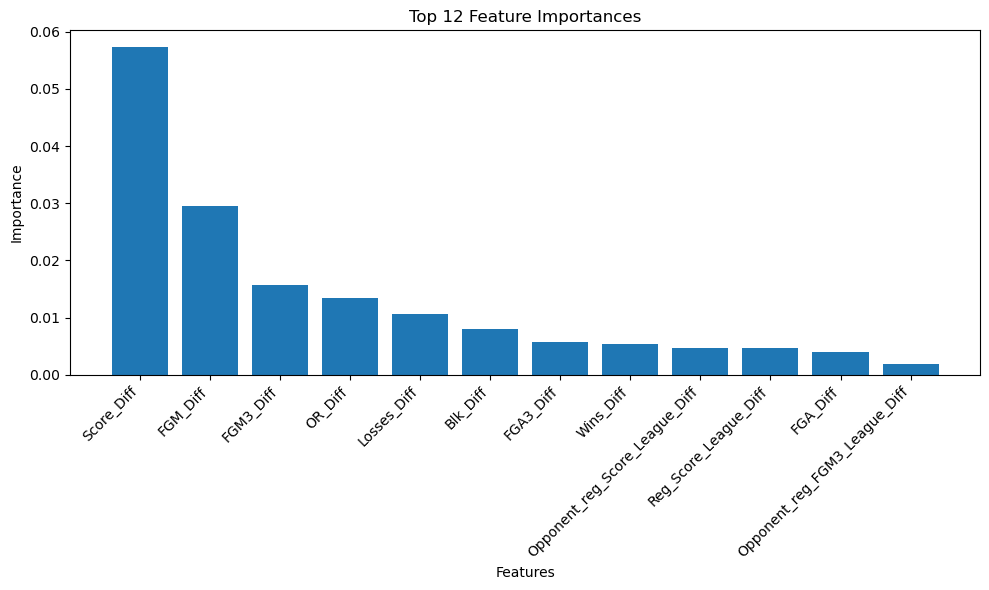

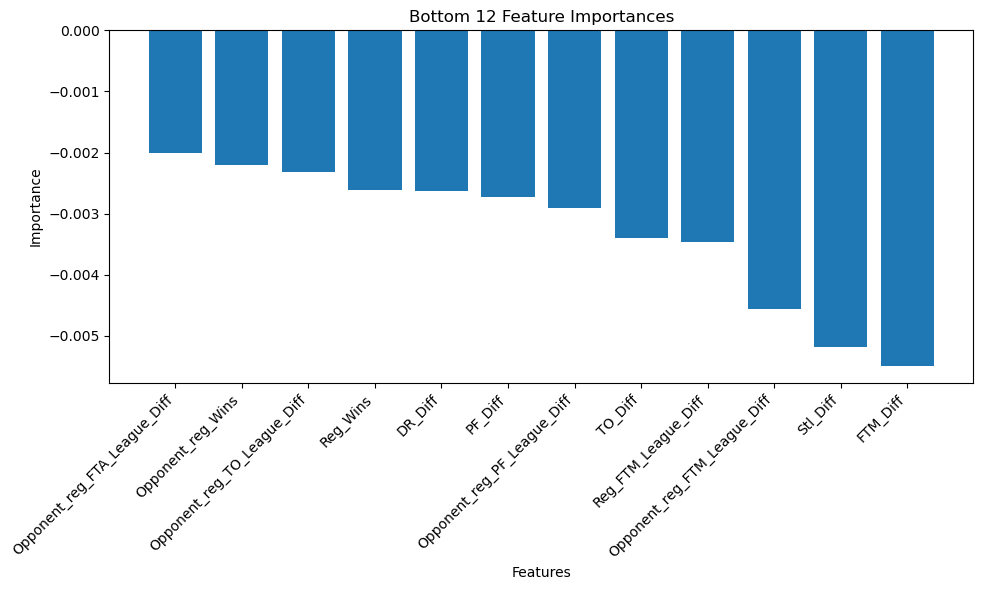

In [8]:
# SVM Classifier With Optimized Params
svm_model=SVC(kernel='linear',C=0.1,gamma='scale',probability=True,random_state=42)

# Go through each of the test seasons and perform permutation feature importance
cv_perm=mf.cross_validated_permutation_importance_seasons(svm_model, training_data,list(set(features)),test_seasons,n_repeats=20)

# Show the top 12 and bottom 12 features
mf.plot_top_bottom_feature_importance(cv_perm, top_n=12, bottom_n=12)

# Refit model with only important features

In [9]:
important_features=[col for col in cv_perm.keys() if cv_perm[col]>0]
classifier_accuracies=[]
brier_scores=[]
for T_season in test_seasons:
    
    train,test=mf.preprocess_time_split(training_data, T_season)  
    svm_classifier,_,accuracy_classifier,y_prob=mf.fit_svm_classifier(train, test,list(set(important_features)),print_details=False,C=.1,gamma='scale',kernel='linear')
    classifier_accuracies.append(accuracy_classifier)
    brier=brier_score_loss(test['efs'],y_prob)
    brier_scores.append(brier)
mean_classifier_accuracy=np.array(classifier_accuracies).mean()


mean_brier=np.array(brier_scores).mean()
print('Average Accuracy: Classifier: ', mean_classifier_accuracy)
print('Average Brier: Classifier: ', mean_brier)
model_dict['SVM_OptParams_RemovedFeatures']=mean_brier

Accuracy: 0.694
Precision: 0.693
Recall: 0.697
F1 Score: 0.695
ROC AUC: 0.768
Concordance Index (using predicted probabilities): 0.652
Accuracy: 0.735
Precision: 0.738
Recall: 0.730
F1 Score: 0.734
ROC AUC: 0.825
Concordance Index (using predicted probabilities): 0.700
Accuracy: 0.728
Precision: 0.722
Recall: 0.741
F1 Score: 0.731
ROC AUC: 0.816
Concordance Index (using predicted probabilities): 0.672
Accuracy: 0.738
Precision: 0.742
Recall: 0.730
F1 Score: 0.736
ROC AUC: 0.833
Concordance Index (using predicted probabilities): 0.709
Accuracy: 0.746
Precision: 0.746
Recall: 0.746
F1 Score: 0.746
ROC AUC: 0.843
Concordance Index (using predicted probabilities): 0.693
Average Accuracy: Classifier:  0.7282239595672432
Average Brier: Classifier:  0.17464425175564155


# Extra Trees Model

In [10]:
classifier_accuracies = []  # Initialize a list to store classifier accuracies for each test season.
brier_scores = []  # Initialize a list to store Brier scores for each test season.

for T_season in test_seasons:  # Iterate through each set of test seasons.

    train, test = mf.preprocess_time_split(training_data, T_season)  # Split the data into training and testing sets.

    # Fit an Extra Trees classifier using specified hyperparameters and important features.
    xtrees_classifier, test, accuracy_classifier, y_pred_proba = mf.fit_extra_trees_classifier(
        train, test, list(set(important_features)), max_depth=None, min_samples_split=2, n_estimators=300, print_details=False
    )

    classifier_accuracies.append(accuracy_classifier)  # Append the classifier's accuracy to the list.

    brier = brier_score_loss(test['efs'], y_pred_proba)  # Calculate the Brier score using predicted probabilities and actual outcomes.
    brier_scores.append(brier)  # Append the Brier score to the list.

mean_classifier_accuracy = np.array(classifier_accuracies).mean()  # Calculate the mean classifier accuracy across all test seasons.
mean_brier = np.array(brier_scores).mean()  # Calculate the mean Brier score across all test seasons.

print('Average Accuracy: Classifier: ', mean_classifier_accuracy)  # Print the mean classifier accuracy.
print('Average Brier: Classifier: ', mean_brier)  # Print the mean Brier score.

model_dict['ExtraTrees_RemovedFeatures'] = mean_brier  # Store the mean Brier score in the model_dict.

Accuracy: 0.687
Precision: 0.690
Recall: 0.677
F1 Score: 0.683
ROC AUC: 0.762
Concordance Index (using predicted probabilities): 0.652
Accuracy: 0.743
Precision: 0.747
Recall: 0.735
F1 Score: 0.741
ROC AUC: 0.798
Concordance Index (using predicted probabilities): 0.679
Accuracy: 0.720
Precision: 0.729
Recall: 0.698
F1 Score: 0.714
ROC AUC: 0.809
Concordance Index (using predicted probabilities): 0.672
Accuracy: 0.722
Precision: 0.719
Recall: 0.730
F1 Score: 0.724
ROC AUC: 0.798
Concordance Index (using predicted probabilities): 0.678
Accuracy: 0.746
Precision: 0.741
Recall: 0.757
F1 Score: 0.749
ROC AUC: 0.831
Concordance Index (using predicted probabilities): 0.692
Average Accuracy: Classifier:  0.7235568190792072
Average Brier: Classifier:  0.1838201787359499


# Add Cluster as a feature
- Use kmeans to cluster the data (using selected features)
- Refit the SVM model with cluster as an added feature
- Interestingly, the cluster feature produced better results when left as a continuous variable, instead of one-hot-encoding.

In [11]:
classifier_accuracies = []  # Initialize a list to store classifier accuracies for each test season.
brier_scores = []  # Initialize a list to store Brier scores for each test season.

for T_season in test_seasons:  # Iterate through each set of test seasons.

    train, test = mf.preprocess_time_split(training_data, T_season)  # Split the data into training and testing sets.
    train, test = mf.add_kmeans_clusters_train_test(train, test, gnn_features, n_clusters=8, random_state=42)  # Add KMeans cluster features to train and test sets.
    # Fit an SVM classifier using important features and KMeans clusters.
    svm_classifier, test, accuracy_classifier, y_prob = mf.fit_svm_classifier(
        train, test, list(set(important_features + [col for col in  test.columns if 'kmeans_cluster' in col])), C=1, kernel='rbf', gamma=.01, print_details=False
    )

    classifier_accuracies.append(accuracy_classifier)  # Append the classifier's accuracy to the list.

    brier = brier_score_loss(test['efs'], y_prob)  # Calculate the Brier score using predicted probabilities and actual outcomes.
    brier_scores.append(brier)  # Append the Brier score to the list.

mean_classifier_accuracy = np.array(classifier_accuracies).mean()  # Calculate the mean classifier accuracy across all test seasons.

mean_brier = np.array(brier_scores).mean()  # Calculate the mean Brier score across all test seasons.

print('Average Accuracy: Classifier: ', mean_classifier_accuracy)  # Print the mean classifier accuracy.
print('Average Brier: Classifier: ', mean_brier)  # Print the mean Brier score.

model_dict['SVM_OptParam_RemovedFeatures_Kmeans'] = mean_brier  # Store the mean Brier score in the model_dict.

Accuracy: 0.699
Precision: 0.694
Recall: 0.711
F1 Score: 0.703
ROC AUC: 0.786
Concordance Index (using predicted probabilities): 0.671
Accuracy: 0.767
Precision: 0.767
Recall: 0.767
F1 Score: 0.767
ROC AUC: 0.828
Concordance Index (using predicted probabilities): 0.702
Accuracy: 0.765
Precision: 0.772
Recall: 0.751
F1 Score: 0.761
ROC AUC: 0.829
Concordance Index (using predicted probabilities): 0.676
Accuracy: 0.722
Precision: 0.723
Recall: 0.720
F1 Score: 0.721
ROC AUC: 0.824
Concordance Index (using predicted probabilities): 0.700
Accuracy: 0.762
Precision: 0.768
Recall: 0.751
F1 Score: 0.759
ROC AUC: 0.839
Concordance Index (using predicted probabilities): 0.703
Average Accuracy: Classifier:  0.7429755981994788
Average Brier: Classifier:  0.1728380613949029


**After swithing the hyperparmeters for the svm model and adding the kmeans feature we see some slight improvement in both brier and accuracy from adding the cluster feature**

## Reevaluation of Hyperparameters After KMeans Feature Addition

After incorporating the KMeans cluster feature, we re-evaluated the optimal hyperparameters for the SVM classifier. The following table summarizes the results of the grid search conducted with the KMeans cluster feature included:

|    |   C | kernel   | gamma   | probability   |   brier_score |
|---:|----:|:---------|:--------|:--------------|--------------:|
|  0 | 0.1 | linear   | scale   | True          |      0.176137 |
|  1 | 0.1 | linear   | auto    | True          |      0.176137 |
|  2 | 0.1 | linear   | 0.1     | True          |      0.176137 |
|  3 | 0.1 | linear   | 1       | True          |      0.176137 |
|  4 | 0.1 | linear   | 0.01    | True          |      0.176137 |
| **19** | **1** | **rbf** | **0.01** | **True** |      **0.1763** |
| 10 | 1   | linear   | scale   | True          |      0.176708 |

As shown, the optimal parameters changed significantly. The **C=1, kernel='rbf', and gamma=0.01** combination yielded the lowest Brier score, demonstrating that these parameters are most effective when the KMeans cluster feature is used as a continuous variable.

It's important to note that the optimal parameters found *before* the KMeans cluster feature was added were linear, C=0.1, and gamma='scale'. This difference highlights the substantial impact of feature engineering on parameter selection and underscores the importance of re-evaluating hyperparameters whenever features are modified.

Future investigations could explore different encoding strategies for the KMeans cluster feature to determine if further optimizations are possible.

# Final Results

In [12]:
best_model=None
best_score=1
for model,score in model_dict.items():
    print(f'{model}: {score}')
    if score<best_score:
        best_score=score
        best_model=model
print(f'\nBest Model\n\n\t{best_model}: {best_score}')

Survival: 0.20856995761980976
SVM_Classifier_Baseline: 0.17629999735324275
SVM_Classifier_OptParam: 0.17613689166591034
SVM_OptParams_GNN: 0.17611518493336084
SVM_OptParams_RemovedFeatures: 0.17464425175564155
ExtraTrees_RemovedFeatures: 0.1838201787359499
SVM_OptParam_RemovedFeatures_Kmeans: 0.1728380613949029

Best Model

	SVM_OptParam_RemovedFeatures_Kmeans: 0.1728380613949029


# Save Models to Disk

In [13]:
kmeans_features=gnn_features
FEATURES=list(set(important_features))
mf.train_and_save_svm_models_women(training_data,kmeans_features,FEATURES,kmeans_clusters=8)

KMeans model saved to: /Users/bcsstaff/Desktop/march-machine-learning-mania-2025/models/kmeans_model_women.joblib
SVM model saved to: /Users/bcsstaff/Desktop/march-machine-learning-mania-2025/models/svm_model_women.joblib
Kmeans Scaler saved to: /Users/bcsstaff/Desktop/march-machine-learning-mania-2025/data/processed/scaler_kmeans_women.joblib
KMeans features saved to: /Users/bcsstaff/Desktop/march-machine-learning-mania-2025/data/processed/kmeans_features_women.joblib
SVM features saved to: /Users/bcsstaff/Desktop/march-machine-learning-mania-2025/data/processed/svm_features_women.joblib
SVM scaler saved to: /Users/bcsstaff/Desktop/march-machine-learning-mania-2025/models/svm_scaler_women.joblib


## Conclusion

This notebook explored various machine learning models to predict outcomes in the Women's NCAA Basketball Tournament, with a focus on optimizing the Brier score. Our analysis revealed that the Support Vector Machine (SVM) classifier, when combined with the KMeans cluster feature and optimized parameters, achieved the best performance.

Specifically:

* The SVM classifier, using the KMeans cluster feature as a continuous variable and parameters C=1, kernel='rbf', and gamma=0.01, outperformed other models, including XGB classifiers, XGB survival models, and Extra Trees classifiers.
* The inclusion of Graph Neural Network (GNN) features did not improve model performance.
* The KMeans cluster feature, when used as a continuous variable, significantly enhanced the SVM's predictive capabilities, demonstrating the importance of feature engineering and parameter optimization.

These results highlight the potential of SVMs, particularly when combined with carefully engineered features and tuned parameters, for predicting tournament outcomes. Future work could explore alternative encoding strategies for the KMeans cluster feature and investigate potential interactions between features to further refine model performance.